# Week 10: the FFT and Linear Algebra

## Library Imports go here

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import curve_fit
import csv

from IPython.display import IFrame
from IPython.core.display import display
import pandas as pd

/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_55753/3175107285.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


## The FFT Functions

### The FFT

<font color = blue>
    
Write a function that implements the FFT algorithm.  It should take as its input a list of positions $[p_j]$, which it should assume has length $2^n$ for some integer $n$, and it should output a list $[P_k]$.  (Because of its recursive nature, it's better to leave this one very simple in terms of the input and output formats.)

In [9]:
def FFT(p_j):
    """
    fast fourier transform method
    
    p_j : list of positions (data set) assuming the length of the data set N = 2^n
    
    returns : fourier transform vals
    """
    N = len(p_j)
    if N == 1:
        return p_j
    else:
        evens = np.array([p_j[2 * i] for i in range(int(np.ceil(N/2)))])
        odds = np.array([p_j[2 * i + 1] for i in range(int(np.floor(N/2)))])
        fevens = FFT(evens)
        fodds = FFT(odds)
    omega = np.exp(2 * np.pi * 1j / (N))
    P_k = np.zeros(N, dtype=complex)
    for k in range(int((N/2))):
        P_k[k] = fevens[k] + omega**k * fodds[k]
    for k in range(int((N/2)), N):
        P_k[k] += fevens[k - int(N/2)] - (omega**(k-int(N/2)) * fodds[k-int(N/2)])
    return P_k

### Testing the FFT

<font color = blue>

Test your function out on the list [1, 2, 3, 4].  Work out by hand what the discrete Fourier transform for this list should be, and include this argument as a **discussion**.

In [12]:
list = np.array([1, 2, 3, 4])
N = 4
FFT(list)

### should get [6, -2 - 2i, -2, -2 + 2i]

array([10.+0.j, -2.-2.j, -2.+0.j, -2.+2.j])

I am arguing that this is correct, to show this we can workout the solution using the discrete fourier transform:
$$P_k = \sum_{j = 0}^{N-1}p_je^{\frac{2\pi i j k}{N}}$$
$$P_0 = 1 * e^0 + 2 * e^0 + 3 * e^0 + 4 * e^0 = 10$$
$$P_1 = 1 * e^0 + 2 * e^{i\frac{\pi}{2}} + 3 * e^{i\pi} + 4 * e^{i \frac{3\pi}{2}} = -2 - 2i$$
$$P_2 = 1 * e^0 + 2 * e^{i\pi} + 3 * e^{i2\pi} + 4 * e^{i 3\pi} = 1 - 2 + 3 - 4 = -2$$
$$P_1 = 1 * e^0 + 2 * e^{i\frac{3\pi}{2}} + 3 * e^{i3\pi} + 4 * e^{i \frac{9\pi}{2}} = 1 - 2i - 3 + 4i = -2 +2i$$

### Fourier Wrapper

<font color = blue>
    
Now write a function structured the same way your first Fourier code (from last time) was set up: it should take as input the list $[p_k]$ and time step $\Delta t$, automatically truncate the input list until it has $2^n$ elements for some integer $n$, then feed that into your FFT code, then generate two lists as output: a list of frequencies $[f_k]$ and the list $[P_k]$.

Test your function on the same simple cosine data you used last time, to be sure it is working properly.  (In order to get perfect agreement between the two, you will need to make the input data list have a perfect power of 2 number of data points -- otherwise the agreement will only be approximate)

In [16]:
def basic_fourier(discrete_vals, del_t):
    """
    function that implements the basic fourier transform of a discrete data set

    discrete_vals : list of p vals of len N (note length of discrete vals is even)
    del_t : length of each time step on time grid

    return : list of frequecies and transform values
    """
    if len(discrete_vals) % 2 == 1:
        discrete_vals = np.delete(discrete_vals, len(discrete_vals) - 1)
    N = len(discrete_vals)
    P_k_vals = np.zeros(N, dtype=complex) 
    f_k_vals = np.zeros(N) 
    
    for k in range(N): #
        for j in range(N):
            P_k_vals[k] += discrete_vals[j] * np.exp(2 * np.pi * 1j * j * k / N)

            if k <= (N/2):
                f_k_vals[k] = k / (N * del_t)
            else:
                f_k_vals[k] = (k - N) / (N * del_t)
    return f_k_vals, P_k_vals

In [17]:
def FFT_full(discrete_vals, del_t):
    """
    function that implements the fast fourier transform a data set

    discrete_vals : list of p vals of len N with length of discrete vals is power of 2 (2^n) 
    del_t : length of each time step on time grid

    return : list of frequecies and transform values
    """
    N = len(discrete_vals)
    if not isinstance(np.log2(N), int):
        discrete_vals = discrete_vals[0:int(2**(np.floor(np.log2(N))))]
    N = len(discrete_vals)
    f_k_vals = np.zeros(N) 

    P_k = FFT(discrete_vals)
    for k in range(N): 
        if k <= (N/2):
            f_k_vals[k] = k / (N * del_t)
        else:
            f_k_vals[k] = (k - N) / (N * del_t)
    return f_k_vals, P_k

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


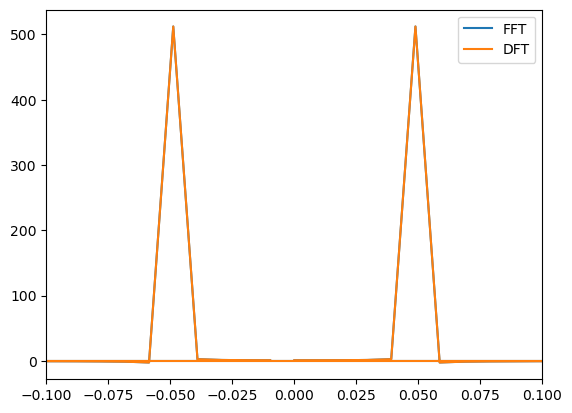

In [18]:
def cos(x):
    """
    Test function for FFT vs DFT comparison
    """
    return np.cos(x)

x = np.linspace(0, 10 * np.pi, 1024)

p_j = cos(x)
f_k_fft, P_k_fft = FFT_full(p_j, .1)
f_k_dft, P_k_dft = basic_fourier(p_j, .1)
plt.plot(f_k_fft, P_k_fft, label = "FFT")
plt.plot(f_k_dft, P_k_dft, label = "DFT")
plt.xlim(-.1, .1)
plt.legend()

### Power Spectrum

<font color = blue>
It's  also handy to have a module that works the same way the previous one did, but outputs the power spectrum instead of the Fourier transform.  Create a variation on the module you just wrote that does so, and then test it on the same basic function, plotting the results.

In [21]:
def FFT_power_spectrum(discrete_vals, del_t):
    """
    function that implements the fast fourier transform a data set

    discrete_vals : list of p vals of len N with length of discrete vals is power of 2 (2^n) 
    del_t : length of each time step on time grid

    return : list of frequecies and transform values
    """
    N = len(discrete_vals)
    if not isinstance(np.log2(N), int):
        discrete_vals = discrete_vals[0:int(2**(np.floor(np.log2(N))))]
    N = len(discrete_vals)
    f_k_vals = np.zeros(N) 
    power_spectrum = np.zeros(N)
    P_k = FFT(discrete_vals)
    for k in range(N): 
        power_spectrum[k] = np.conj(P_k[k]) * P_k[k]
        if k <= (N/2):
            f_k_vals[k] = k / (N * del_t)
        else:
            f_k_vals[k] = (k - N) / (N * del_t)
    return f_k_vals, power_spectrum

/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_55753/1223846931.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  power_spectrum[k] = np.conj(P_k[k]) * P_k[k]
/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_55753/3955063620.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  power_spectrum_dft[i] = np.conj(P_k_dft[i]) * P_k_dft[i]


Text(0.5, 1.0, 'power spectrum for test data')

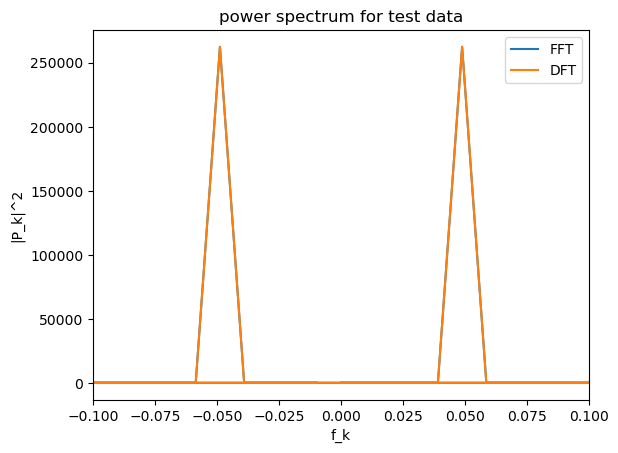

In [96]:
f_k_fft, power_spectrum_fft = FFT_power_spectrum(p_j, .1)
f_k_dft, P_k_dft = basic_fourier(p_j, .1)
power_spectrum_dft = np.zeros(len(power_spectrum_fft))
for i in range(len(P_k_dft)):
    power_spectrum_dft[i] = np.conj(P_k_dft[i]) * P_k_dft[i]
plt.plot(f_k_fft, power_spectrum_fft, label = "FFT")
plt.plot(f_k_dft, power_spectrum_dft, label = "DFT")
plt.xlim(-.1, .1)
plt.legend()
plt.xlabel("f_k")
plt.ylabel("|P_k|^2")
plt.title("power spectrum for test data")

## Timing of the FFT

<font color = blue>
    
Create a function that takes as input an integer $N$ and outputs the time required to find the Fourier transform (using the FFT) of the function $p(t) = \cos 40\pi t$ on the interval $[0, 10]$ with $\Delta t = T/N$.  Use this function to create lists whose elements are of the form $[N]$ and $[T_N]$, with $N = 2, 4, 8, 16, 32, \dots, 2^{16}$.  Plot the results, and in a **discussion**, compare them with the timing of the original discrete Fourier transform code.  

Text(0.5, 1.0, 'N vs time')

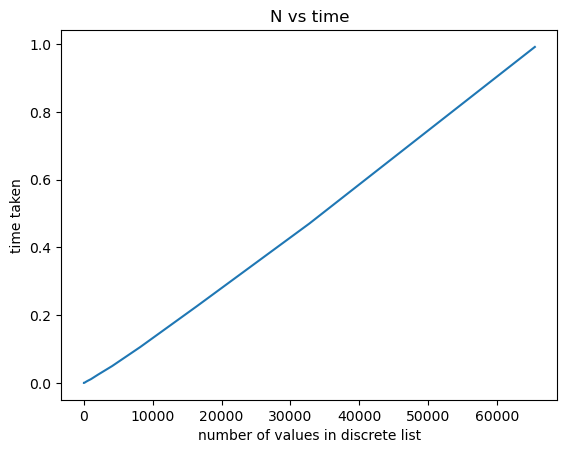

In [25]:
def timing(N):
    """
    function that outputs the time required to find the fourier transform of our test function with del_t = T / N
    """
    final_t = 10
    del_t = final_t / N
    time_list = np.linspace(0, final_t, int(N))

    def p(t):
        """
        test function to create our discrete values
        """
        return np.cos(40 * np.pi * t)

    discrete_vals = np.array([p(time) for time in time_list])
    start = time.time()
    f_k, P_k = FFT_full(discrete_vals, del_t)
    end = time.time()
    return end - start

N_vals = np.array([2**(i + 1) for i in range(16)])
times = np.array([])

for N in N_vals:
    times = np.append(times, timing(N))

plt.plot(N_vals, times)
plt.xlabel("number of values in discrete list")
plt.ylabel("time taken")
plt.title("N vs time")

What we can see in this figure is that the time it takes to complete the fourier analysis scales (almost) linearly. This is because as we found in class, the runtime of our algorithm is O(nlogn) which isnt linear, but as n gets larger it becomes $\approx$ = O(n). We can see this logn component in the beginning of the graph when there are a small number of items in our list because the curve looks much less like a line then the end of the graph.

## Data Analysis: Pulse Periodicity

<font color = blue>
Consider the (artificially created) data set stored on Nexus titled "pulse.csv."  It represents a possible data set of the some signal that pulses at regular intervals.  These pulses are not completely identical, and riding on top of the signal is a significant amount of noise, such that without the tools of Fourier transform it might be impossible to tell that there is any sort of regularity.  With these tools, on the other hand, it is possible to determine with significant accuracy the periodicity of the small, regular signal hiding in all of the noise.

### Original Data

<font color = blue>
Begin by importing in the original data set, converting it to the proper format (it is originally a list of ordered pairs $[t, p]$), and plotting it.  Try various time ranges.  Make an initial guess as to what you think the period of the pulse signal is.  (If it appears to be impossible to tell, don't worry, that's the point.)  

Text(0.5, 1.0, 'pulse data')

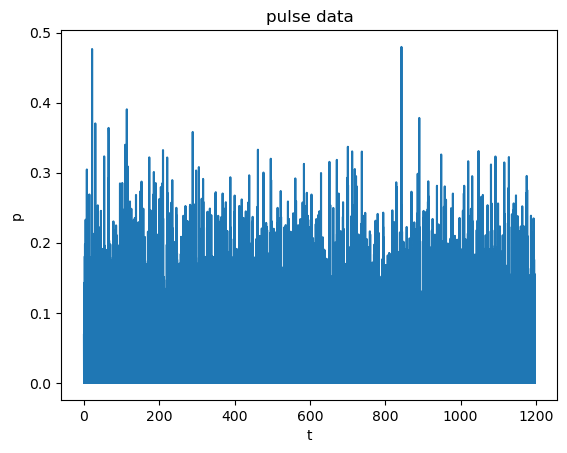

In [99]:
data = np.genfromtxt("/Users/theosteiger/Phy 310/Computational Physics Pulse.csv", delimiter=",")

t = data[:, 0]
p = data[:, 1]

plt.plot(t, p)
plt.ylabel("p")
plt.xlabel("t")
plt.title("pulse data")

As a guess, I would say that the period of the data above is roughly 100 because roughly speaking the highest peaks seem to be spaced out by about 100 (time).

### Pre-Processing the Data

#### Determining the Time Step

<font color = blue>
To perform the analysis, it is necessary to work out what the time step $\Delta t$ of the original data is.  Do so.

In [49]:
print(t)

[1.0000e-01 2.0000e-01 3.0000e-01 ... 1.1970e+03 1.1971e+03 1.1972e+03]


$\Delta t$ for the initial data is .1

#### Subtracting an Offset

<font color = blue>
    
You should notice that the signal provided is always positive.  If we are thinking of this data as representing oscillations, they are oscilations around some positive offset, rather than around zero.  In a **discussion**, explain why an offset presents a problem for Fourier analysis.  (What would happen if you looked at the Fourier transofrm of a constant?)  

You can calculate the "offset" by finding the average value of the data set, and then you can subtract this off of the original data set, to have a set centered around zero.  Do so.

This offset would cause a problem because the fourier analysis would focus on the fact that all of the data is positive rather than the period therefore it would cause the frequency to peak at 0 therefore giving us an infinite period because the analysis did not properly identify the oscillations.

Text(0.5, 1.0, 'centered pulse data')

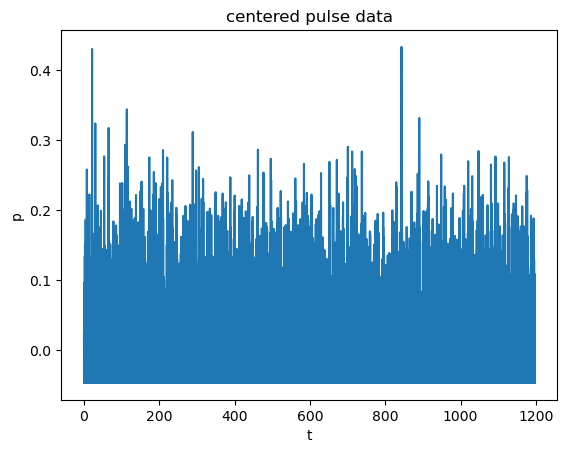

In [101]:
mean = np.mean(p)

for i in range(len(p)):
    p[i] = p[i] - mean

plt.plot(t, p)
plt.ylabel("p")
plt.xlabel("t")
plt.title("centered pulse data")

### * Power Spectrum

<font color = blue>
    
Now use the function you created earlier to generate the power spectrum of the data.  Plot the results, and use *this* to work out what the period of the pulsing signal was, and explain your analysis in a **discussion**.

period = 11.87


/var/folders/xj/m3v1xx6n4rl7kwn57frntw_r0000gn/T/ipykernel_55753/1223846931.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  power_spectrum[k] = np.conj(P_k[k]) * P_k[k]


Text(0.5, 1.0, 'Power spectrum of pulse data')

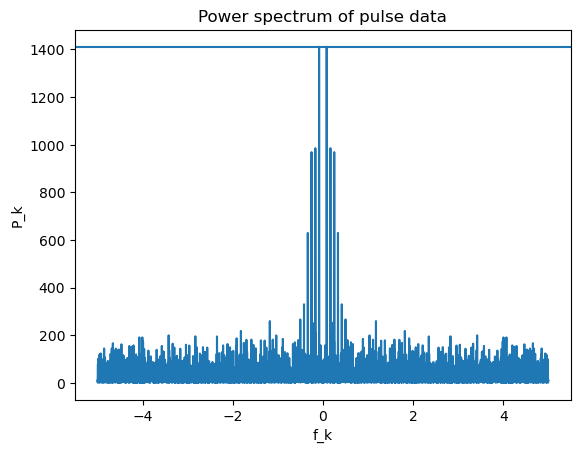

In [82]:
del_t = .1
f_k, P_k = FFT_power_spectrum(p, del_t)

max_index = np.argmax(P_k)
period = 1 / f_k[max_index]
print(f"period = {round(period, 2)}")

plt.plot(f_k, P_k)
plt.axhline(P_k[max_index], label = "max")
plt.xlabel("f_k")
plt.ylabel("P_k")
plt.title("Power spectrum of pulse data")

From my analysis, I found the period of the data by analyzing the power spectrum plot to find the frequency at which the power spetrum is maximized. From this frequency, I then took its inverse to find the period. Interestingly, in this graph we can see the noise by identifying the fact that there are small peaks across the entire range of frequencies. The final period I found that the data had was 11.87.

(0.0, 100.0)

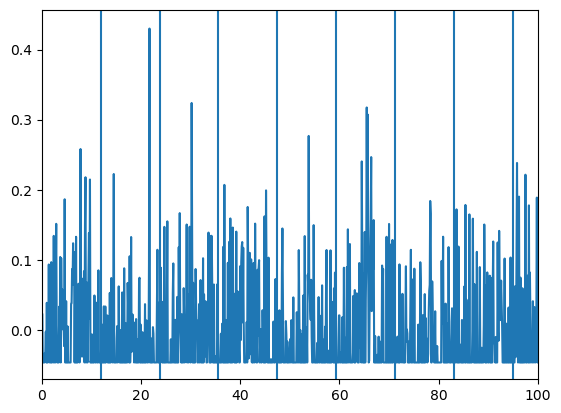

In [91]:
plt.plot(t, p)
peaks = np.array([(i + 1) * 11.87 for i in range(int(1200/period))])
for peak in peaks:
    plt.axvline(peak)
plt.xlim(0, 100)

## Basic Inversion Functions

### QR Decomposition

<font color = blue>
Write a function that takes as input a square $N \times N$ matrix $\mathbb{M}$ and outputs a pair of matrices $[\mathbb{Q}, \mathbb{R}]$, where $\mathbb{Q}$ is orthogonal, $\mathbb{R}$ is upper triangular, and $\mathbb{M} = \mathbb{Q}\mathbb{R}$.  Test your function on the matrix

.

$$
\mathbb{M} = \left[\begin{array}{cccc} 1 & 2 & 3 & 4 \\ 5 & 6 & 7 & 8 \\ 9 & 10 & 0 & 12 \\ 13 & 14 & 15 & 0 \end{array}\right]
$$

.

Confirm that the function is working by checking all three features of your results: that $\mathbb{Q}$ is orthogonal, that $\mathbb{R}$ is upper triangular, and that $\mathbb{M} = \mathbb{Q}\mathbb{R}$.

### Failure Mode

<font color = blue>
Now test your function on the matrix

.

$$
\mathbb{M} = \left[\begin{array}{cccc} 1 & 2 & 3 & 4 \\ 5 & 6 & 7 & 8 \\ 9 & 10 & 11 & 12 \\ 13 & 14 & 15 & 16 \end{array}\right]
$$

.

What goes wrong?  Explain in a **discussion** why the matrix above is unsuitable for QR decomposition

### Inverting an Upper Triangular Matrix

<font color = blue>
Now write a function that solves the linear equation

$$
\mathbb{R}\vec{x} = \vec{b}
$$

It should take as inputs an upper triangular matrix $\mathbb{R}$ and a vector $\vec{b}$, and output a vector $\vec{x}$.  Test your function by using the upper triangular matrix generated in the first part of this assignment, and the vector

.

$$
\left[\begin{array}{c} 1 \\ 1 \\ 1 \\ 1 \end{array}\right]
$$

.

Find a matrix $\mathbb{R}$ for which your function will not work, and explain in a **discussion** what goes wrong.  Is there a choice of vector $\vec{b}$ that will create problems?

### Matrix Inverter

<font color = blue>
Now use the pieces you have created to solve the general problem

$$
\mathbb{M}\vec{x} = \vec{b}
$$

by first decomposing $\mathbb{M} = \mathbb{Q}\mathbb{R}$, and then solving

$$
\mathbb{R}\vec{x} = \mathbb{Q}^{T}\vec{b}
$$

Your function should take as inputs an $N \times N$ matrix $\mathbb{M}$, and an $N$-component vector $\vec{b}$.  Have your function print an error message and return a non-sensical result in the event that $\mathbb{M}$ is not square, that $\vec{b}$ does not have the correct number of components, or that $\mathbb{M}$ is not invertible.

Check your code using the matrices and vector we used earlier.

## Circuit Analysis

### * Circuit 1

In [ ]:
filepath = "circuit.pdf"
IFrame(filepath, width=700, height=400)

<font color = blue>
    
Use your matrix inverter to find the currents in the circuit above, analyzed in class.  Choose at least four different sets of values for the resistors and the input voltage, and **discuss** your results.

### * Circuit 2

In [ ]:
filepath = "circuit2.pdf"
IFrame(filepath, width=700, height=400)

<font color = blue>
    
Now analyze the circuit below in a similar manner.  This time, you will have to convert the problem into matrix form yourself.  (Include your work on that in the notebook as a **discussion**.)

## Final Project Work

<font color = blue>
Turn in your "final project" notebook as well, updated to include your work from this week.

At the end, include a brief discussion of what you *intended* to accomplish as compared with what you *did* accomplish, as well as a plan for the rest of the project.